In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import models.lin as lin
import models.rf as rf
import models.fcnn as fcnn
import models.cnn as cnn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch

In [2]:
def read_dataset(filename):
    df_input=pd.read_hdf(filename,'df_input')
    df_time=pd.read_hdf(filename,'df_time')
    df_freq_int=pd.read_hdf(filename,'df_freq_int')

    #get the arrays and print them
    print('Input DF')
    print(df_input)

    print('----')
    print('Time values')
    df_time_val=df_time.loc[0]
    print(df_time_val)

    print('----')
    print("Intensity")
    df_time= df_time.drop([0]) #drop the time values
    df_time.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    #df_time = df_time.drop('index', axis=1)
    print(df_time)

    print('----')
    print("Freq values")
    df_freq_val=df_freq_int.loc[0]
    print(df_freq_val)

    print('----')
    print("Frequency intesity")
    df_freq_int= df_freq_int.drop([0]) #drop the freq values
    df_freq_int.reset_index(inplace=True,drop=True)
    #df_freq_int = df_freq_int.drop('index', axis=1)
    print(df_freq_int)
    
    return df_input,df_time_val,df_time,df_freq_val,df_freq_int

In [3]:
#Drop the shots below some value from the raw max distribution
def clean_shots_below(value,df_input,df_time,df_freq_int):
    maxval_freq=df_freq_int.max(axis=1)
    meanval=maxval_freq.mean()
    twosigma=2*maxval_freq.std()
    print('')
    print('Shots with max val below this will be discarded:',value)
    print('')

    #get the indexes of the shots that don't fulfilll the requirement
    #badpoints_up=maxval_freq.index[(maxval_freq>(meanval+twosigma))].tolist()
    badpoints_down=maxval_freq.index[(maxval_freq<value)].tolist()

    #Drop those shots from the databases
    df_input_clean=df_input.drop(badpoints_down)

    df_time_clean=df_time.drop(badpoints_down)

    df_freq_int_clean=df_freq_int.drop(badpoints_down)

    #reset their indexes
    df_input_clean.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    df_time_clean.reset_index(inplace=True,drop=True)
    df_freq_int_clean.reset_index(inplace=True,drop=True)

    #TESTING
    #print('Testing!')
    #print(df_freq_int_clean)
    #test the histogram
    #test_maxval_freq=df_freq_int_clean.max(axis=1)
    #test_maxval_freq.hist(bins=50)
    
    return df_input_clean,df_time_clean,df_freq_int_clean

In [4]:
#Drop the shots >65000 from the raw max distribution
def clean_shots_above(value,df_input,df_time,df_freq_int):
    maxval_freq=df_freq_int.max(axis=1)
    meanval=maxval_freq.mean()
    twosigma=2*maxval_freq.std()
    print('')
    print('Shots with max val above this will be discarded:',value)
    print('')

    #get the indexes of the shots that don't fulfilll the requirement
    #badpoints_up=maxval_freq.index[(maxval_freq>(meanval+twosigma))].tolist()
    badpoints_down=maxval_freq.index[(maxval_freq>value)].tolist()

    #Drop those shots from the databases
    df_input_clean=df_input.drop(badpoints_down)

    df_time_clean=df_time.drop(badpoints_down)

    df_freq_int_clean=df_freq_int.drop(badpoints_down)

    #reset their indexes
    df_input_clean.reset_index(inplace=True,drop=True) #to start again from 0 (as the other DataFrames)
    df_time_clean.reset_index(inplace=True,drop=True)
    df_freq_int_clean.reset_index(inplace=True,drop=True)

    #TESTING
    #print('Testing!')
    #print(df_freq_int_clean)
    #test the histogram
    #test_maxval_freq=df_freq_int_clean.max(axis=1)
    #test_maxval_freq.hist(bins=50)
    
    return df_input_clean,df_time_clean,df_freq_int_clean

In [5]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    #print(y_test.iloc[shot_index])
    #print(y_test.iloc[shot_index])
    id_value=y_test.iloc[shot_index].name
    #print(df_time_clean.loc[id_value])
    #print(y_test_reset.loc[shot_index])
    #print(df_input_clean.loc[id_value])
    return(df_input['shot number'].loc[id_value])

In [6]:
def write_metrics(y_test, y_predict):
    print(' ')
    print('The mean squared error is:',mean_squared_error(y_test, y_predict))
    print('The mean absolute error:',mean_absolute_error(y_test,y_predict))
    print('Error in area under the curve:',abs(np.trapz(y_predict)-np.trapz(y_test)))
    print('Difference in std deviation:',abs(np.std(y_test)-np.std(y_predict)))
    print(' ')

## Read the first (24_03_14) dataset

In [7]:
filename='galadriel_dataset.h5'
df_input_240314,df_time_val_240314,df_time_240314,df_freq_val_240314,df_freq_int_240314=read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0             4731   34900  -17000 -3700000.0
1             4733   34900  -17000 -4600000.0
2             4734   34900  -17000 -4600000.0
3             4735   34900  -17000 -4600000.0
4             4736   34900  -17000 -4500000.0
...            ...     ...     ...        ...
12156        17147   35300   20000 -3800000.0
12157        17148   35300   20000 -3800000.0
12158        17149   35300   20000 -3800000.0
12159        17150   35300   20000 -3700000.0
12160        17151   35300   20000 -3700000.0

[12161 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
18    94.466005
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         

In [8]:
#Get the clean shots
minval=8000
df_input_clean_240314,df_time_clean_240314,df_freq_int_clean_240314=clean_shots_below(minval,
    df_input_240314,df_time_240314,df_freq_int_240314)


Shots with max val below this will be discarded: 8000



## Read second dataset

In [9]:
filename='galadriel_dataset_24_04_11.h5'
df_input_240411,df_time_val_240411,df_time_240411,df_freq_val_240411,df_freq_int_240411=read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0            36612   34900  -17000 -4600000.0
1            36613   34900  -17000 -4600000.0
2            36614   34900  -17000 -4500000.0
3            36615   34900  -17000 -4500000.0
4            36616   34900  -17000 -4500000.0
...            ...     ...     ...        ...
15503        52116   35400   29000 -3800000.0
15504        52117   35400   29000 -3800000.0
15505        52118   35400   29000 -3700000.0
15506        52119   35400   29000 -3700000.0
15507        52120   35400   29000 -3700000.0

[15508 rows x 4 columns]
----
Time values
0    -94.466005
1    -83.969782
2    -73.473559
3    -62.977336
4    -52.481114
5    -41.984891
6    -31.488668
7    -20.992445
8    -10.496223
9      0.000000
10    10.496223
11    20.992445
12    31.488668
13    41.984891
14    52.481114
15    62.977336
16    73.473559
17    83.969782
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         4         5     

In [10]:
#Add an extra column for the time to eb consistent with first dataset
df_time_val_240411=pd.concat([df_time_val_240411,pd.Series([94.466],dtype='float64')],ignore_index=True)

df_time_240411['18']=0.000
df_time_240411.columns=df_time_240411.columns.astype(str)

In [11]:
#Get the clean shots
maxval=65000
minval=27000
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411=clean_shots_above(maxval,
    df_input_240411,df_time_240411,df_freq_int_240411)
df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411=clean_shots_below(minval,
    df_input_clean_240411,df_time_clean_240411,df_freq_int_clean_240411)


Shots with max val above this will be discarded: 65000


Shots with max val below this will be discarded: 27000



## Read third dataset

In [12]:
filename='galadriel_dataset_24_05_09.h5'
df_input_240509,df_time_val_240509,df_time_240509,df_freq_val_240509,df_freq_int_240509=read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0            53143   34900  -17000 -4600000.0
1            53144   34900  -17000 -4600000.0
2            53146   34900  -17000 -4500000.0
3            53147   34900  -17000 -4500000.0
4            53149   34900  -17000 -4400000.0
...            ...     ...     ...        ...
10335        68647   35400   29000 -3800000.0
10336        68648   35400   29000 -3800000.0
10337        68650   35400   29000 -3700000.0
10338        68651   35400   29000 -3700000.0
10339        68653   35400   29000 -3600000.0

[10340 rows x 4 columns]
----
Time values
0    -83.969782
1    -73.473559
2    -62.977336
3    -52.481114
4    -41.984891
5    -31.488668
6    -20.992445
7    -10.496223
8      0.000000
9     10.496223
10    20.992445
11    31.488668
12    41.984891
13    52.481114
14    62.977336
15    73.473559
16    83.969782
Name: 0, dtype: float64
----
Intensity
             0         1         2         3         4         5         6   \
0     

In [13]:
#Add aextra columns for the time to eb consistent with first dataset
shift_col=np.linspace(1,17,17,dtype='int')
df_time_240509.columns=shift_col
df_time_240509.insert(0,'0',0.0)
df_time_240509.insert(18,'18',0.0)

df_time_val_240509=pd.concat([pd.Series([-94.466],dtype='float64'),df_time_val_240509],ignore_index=True)
df_time_val_240509=pd.concat([df_time_val_240509,pd.Series([94.466],dtype='float64')],ignore_index=True)
df_time_240509.columns=df_time_240509.columns.astype(str)
#print(df_time_val_240509)
#print(shift_col)
#print(df_time_240509)

In [14]:
maxval=30000
df_input_clean_240509,df_time_clean_240509,df_freq_int_clean_240509=clean_shots_above(maxval,
    df_input_240509,df_time_240509,df_freq_int_240509)


Shots with max val above this will be discarded: 30000



### Define the inputs and targets

In [15]:
#DATASET 240314
X_240314=df_input_clean_240314[['order2','order3','order4']]
y_240314=df_time_clean_240314

#split into train and test set
X_train_240314, X_test_240314, y_train_240314, y_test_240314 = train_test_split(X_240314, y_240314, test_size=0.3)#, random_state=101)

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240314=y_test_240314.reset_index(drop=True)

In [16]:
#DATASET 240411
X_240411=df_input_clean_240411[['order2','order3','order4']]
y_240411=df_time_clean_240411

#split into train and test set
X_train_240411, X_test_240411, y_train_240411, y_test_240411 = train_test_split(X_240411, y_240411, test_size=0.3)#, random_state=101)

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240411=y_test_240411.reset_index(drop=True)

In [17]:
#DATASET 240509
X_240509=df_input_clean_240509[['order2','order3','order4']]
y_240509=df_time_clean_240509

#split into train and test set
X_train_240509, X_test_240509, y_train_240509, y_test_240509 = train_test_split(X_240509, y_240509, test_size=0.3)#, random_state=101)

#Reset the index on y_test to have the same indexes as y_predict
y_test_reset_240509=y_test_240509.reset_index(drop=True)

## Train the models (forward)

### Lin model

In [18]:
#DATASET 240314
lin_model_forward_240314=lin.fit_lin_model(X_train_240314,y_train_240314)
y_predict_lin_forward_240314=lin.make_lin_prediction(lin_model_forward_240314,X_test_240314)

In [19]:
#DATASET 240411
lin_model_forward_240411=lin.fit_lin_model(X_train_240411,y_train_240411)
y_predict_lin_forward_240411=lin.make_lin_prediction(lin_model_forward_240411,X_test_240411)

In [20]:
#DATASET 240509
lin_model_forward_240509=lin.fit_lin_model(X_train_240509,y_train_240509)
y_predict_lin_forward_240509=lin.make_lin_prediction(lin_model_forward_240509,X_test_240509)

### Random forest

In [21]:
#DATASET 240314
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_forward_240314=rf.fit_random_forest(X_train_240314,y_train_240314,n_estimators, max_features,max_depth, random_state)
y_predict_forest_forward_240314=rf.make_rf_prediction(rf_model_forward_240314,X_test_240314)

In [22]:
#DATASET 240411
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_forward_240411=rf.fit_random_forest(X_train_240411,y_train_240411,n_estimators, max_features,max_depth, random_state)
y_predict_forest_forward_240411=rf.make_rf_prediction(rf_model_forward_240411,X_test_240411)

In [23]:
#DATASET 240509
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

rf_model_forward_240509=rf.fit_random_forest(X_train_240509,y_train_240509,n_estimators, max_features,max_depth, random_state)
y_predict_forest_forward_240509=rf.make_rf_prediction(rf_model_forward_240509,X_test_240509)

## Error distribution

In [24]:
#study the erro distribution between the prediction and the actual value
#Use as imput test_reset so both have the same index
def error_dist(y_prediction,y_test):
    df_aux=abs(y_test-y_prediction)
    df_error=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    #print(df_error)

    print('ID max error:',df_error.idxmax())
    print('Max error:',df_error.max())
    return df_error


In [25]:
#study the erro distribution between the prediction and the actual value
#Use as imput test_reset so both have the same index
def error_dist_big(y_prediction,y_test):
    df_aux=abs(y_test-y_prediction)
    df_aux=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    df_error=pd.DataFrame(df_aux,columns=['mae'])
    
    df_aux=abs(y_test-y_prediction)**2
    df_aux=df_aux.sum(axis=1)/y_test.shape[1] #sum error / num columns
    df_error['mse']=df_aux
    #print(df_error)

    df_error['area']=abs(np.trapz(y_prediction)-np.trapz(y_test))
    
    df_error['std']=abs(np.std(y_test,axis=1)-np.std(y_prediction,axis=1))
    
    print('ID max error:',df_error.idxmax())
    print('Max error:',df_error.max())
    return df_error

In [26]:
#DATASET 240314
df_error_big_forward_lin_240314=error_dist_big(y_predict_lin_forward_240314,y_test_reset_240314)

df_error_big_forward_rf_240314=error_dist_big(y_predict_forest_forward_240314,y_test_reset_240314)

#DATASET 240411
df_error_big_forward_lin_240411=error_dist_big(y_predict_lin_forward_240411,y_test_reset_240411)

df_error_big_forward_rf_240411=error_dist_big(y_predict_forest_forward_240411,y_test_reset_240411)

#DATASET 240509
df_error_big_forward_lin_240509=error_dist_big(y_predict_lin_forward_240509,y_test_reset_240509)

df_error_big_forward_rf_240509=error_dist_big(y_predict_forest_forward_240509,y_test_reset_240509)

ID max error: mae     2424
mse     2424
area    3643
std     1210
dtype: int64
Max error: mae     0.134033
mse     0.036701
area    2.087282
std     0.058031
dtype: float64
ID max error: mae     3419
mse     3419
area    3419
std     2764
dtype: int64
Max error: mae     0.096594
mse     0.022984
area    1.665468
std     0.059286
dtype: float64
ID max error: mae     2496
mse     4239
area    1290
std     2533
dtype: int64
Max error: mae     0.426278
mse     0.264860
area    5.114175
std     0.103481
dtype: float64
ID max error: mae     1618
mse     1618
area    1618
std     2659
dtype: int64
Max error: mae     0.393953
mse     0.229813
area    6.086683
std     0.179368
dtype: float64
ID max error: mae     1788
mse     1788
area     152
std      152
dtype: int64
Max error: mae     0.157203
mse     0.068099
area    2.895802
std     0.084388
dtype: float64
ID max error: mae     359
mse     359
area    359
std     359
dtype: int64
Max error: mae     0.169900
mse     0.068740
area    2.87068

### MAE

In [27]:
#DATASET 240314
df_error_forward_lin_240314=error_dist(y_predict_lin_forward_240314,y_test_reset_240314)

df_error_forward_rf_240314=error_dist(y_predict_forest_forward_240314,y_test_reset_240314)

#DATASET 240411
df_error_forward_lin_240411=error_dist(y_predict_lin_forward_240411,y_test_reset_240411)

df_error_forward_rf_240411=error_dist(y_predict_forest_forward_240411,y_test_reset_240411)

#DATASET 240509
df_error_forward_lin_240509=error_dist(y_predict_lin_forward_240509,y_test_reset_240509)

df_error_forward_rf_240509=error_dist(y_predict_forest_forward_240509,y_test_reset_240509)

ID max error: 2424
Max error: 0.13403321606012386
ID max error: 3419
Max error: 0.09659432880242269
ID max error: 2496
Max error: 0.4262777928854164
ID max error: 1618
Max error: 0.3939525362740184
ID max error: 1788
Max error: 0.15720318024331634
ID max error: 359
Max error: 0.1699002454970759


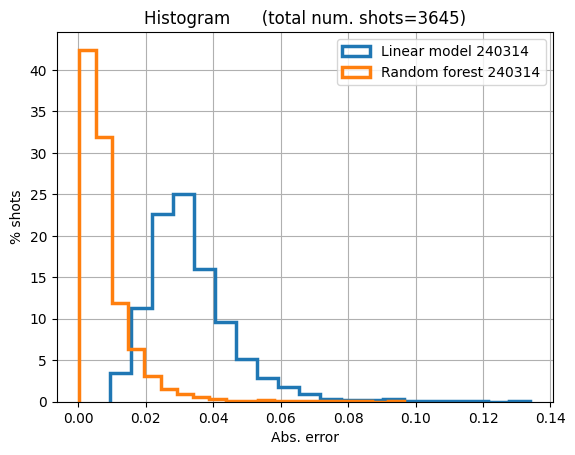

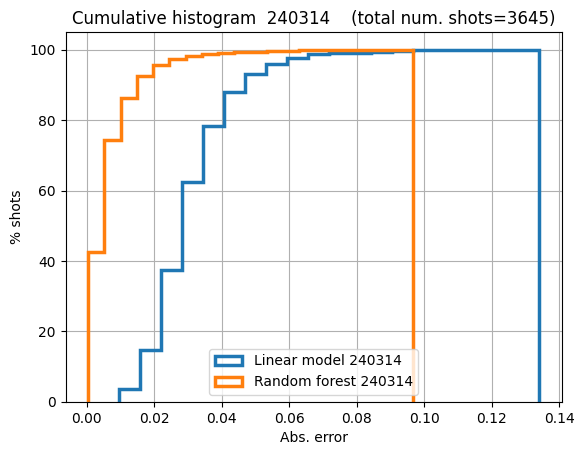

In [28]:
weights_forward_lin_240314 = 100*np.ones_like(df_error_forward_lin_240314) / len(df_error_forward_lin_240314)
weights_forward_rf_240314 = 100*np.ones_like(df_error_forward_rf_240314) / len(df_error_forward_rf_240314)

df_error_forward_lin_240314.hist(bins=20,weights=weights_forward_lin_240314,histtype="step",linewidth=2.5, label='Linear model 240314')
df_error_forward_rf_240314.hist(bins=20,weights=weights_forward_rf_240314,histtype="step",linewidth=2.5, label='Random forest 240314')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram      (total num. shots='+str(len(weights_forward_lin_240314))+')')
plt.legend()
plt.show()

df_error_forward_lin_240314.hist(bins=20,weights=weights_forward_lin_240314,cumulative=True,histtype="step",linewidth=2.5, label='Linear model 240314')
df_error_forward_rf_240314.hist(bins=20,weights=weights_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram  240314    (total num. shots='+str(len(df_error_forward_rf_240314))+')')
plt.legend()
plt.show()

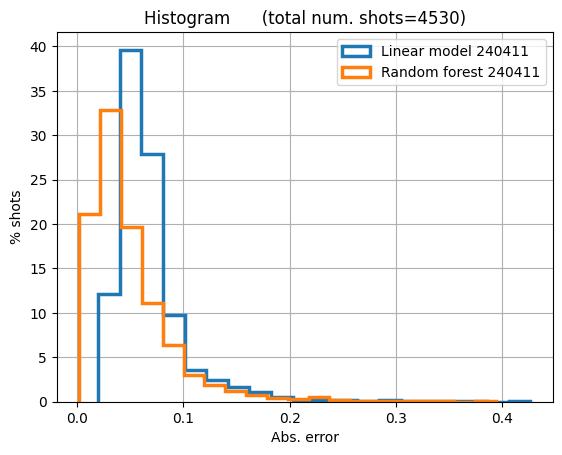

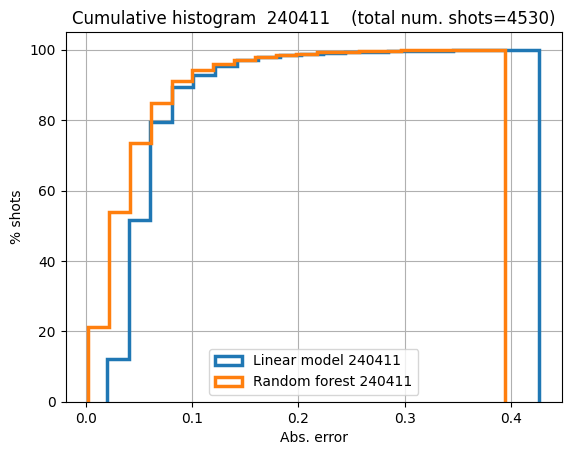

In [29]:
weights_forward_lin_240411 = 100*np.ones_like(df_error_forward_lin_240411) / len(df_error_forward_lin_240411)
weights_forward_rf_240411 = 100*np.ones_like(df_error_forward_rf_240411) / len(df_error_forward_rf_240411)

df_error_forward_lin_240411.hist(bins=20,weights=weights_forward_lin_240411,histtype="step",linewidth=2.5, label='Linear model 240411')
df_error_forward_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='Random forest 240411')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram      (total num. shots='+str(len(weights_forward_lin_240411))+')')
plt.legend()
plt.show()

df_error_forward_lin_240411.hist(bins=20,weights=weights_forward_lin_240411,cumulative=True,histtype="step",linewidth=2.5, label='Linear model 240411')
df_error_forward_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram  240411    (total num. shots='+str(len(df_error_forward_rf_240411))+')')
plt.legend()
plt.show()

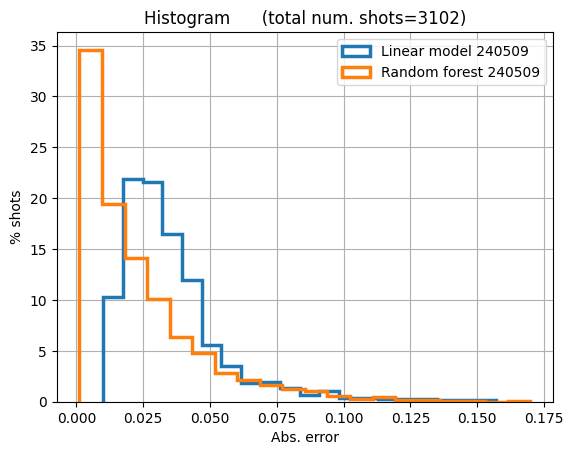

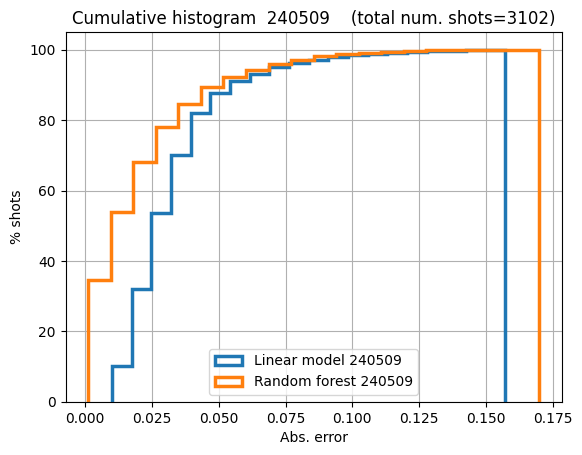

In [30]:
weights_forward_lin_240509 = 100*np.ones_like(df_error_forward_lin_240509) / len(df_error_forward_lin_240509)
weights_forward_rf_240509 = 100*np.ones_like(df_error_forward_rf_240509) / len(df_error_forward_rf_240509)

df_error_forward_lin_240509.hist(bins=20,weights=weights_forward_lin_240509,histtype="step",linewidth=2.5, label='Linear model 240509')
df_error_forward_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram      (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_forward_lin_240509.hist(bins=20,weights=weights_forward_lin_240509,cumulative=True,histtype="step",linewidth=2.5, label='Linear model 240509')
df_error_forward_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram  240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

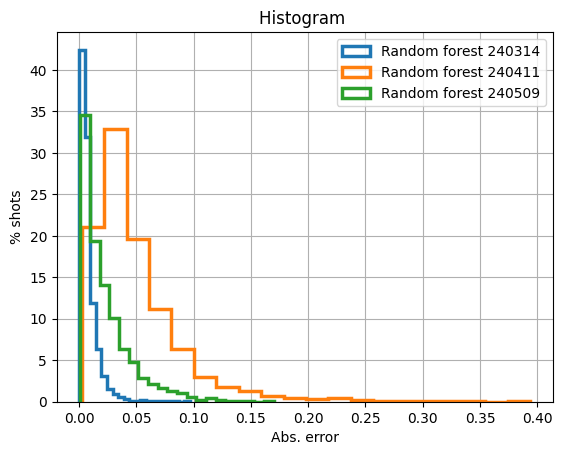

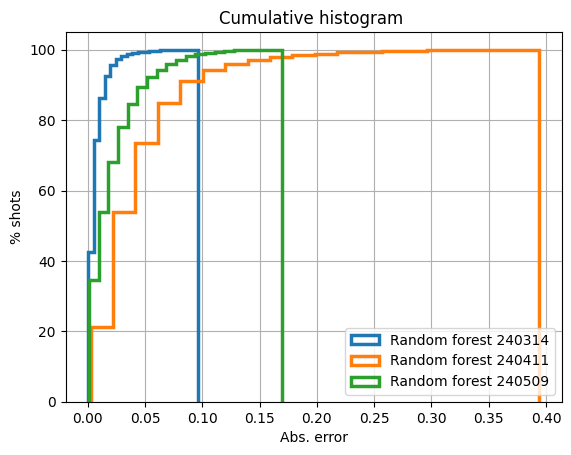

In [31]:
df_error_forward_rf_240314.hist(bins=20,weights=weights_forward_rf_240314,histtype="step",linewidth=2.5, label='Random forest 240314')
df_error_forward_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='Random forest 240411')
df_error_forward_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram ')#     (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_forward_rf_240314.hist(bins=20,weights=weights_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
df_error_forward_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
df_error_forward_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram ')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

## CHECK OTHER METRICS

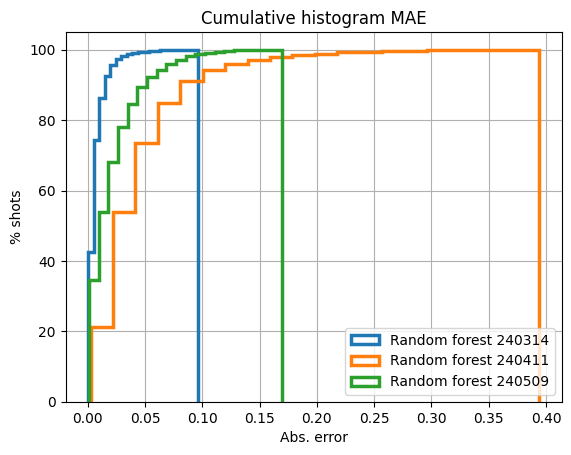

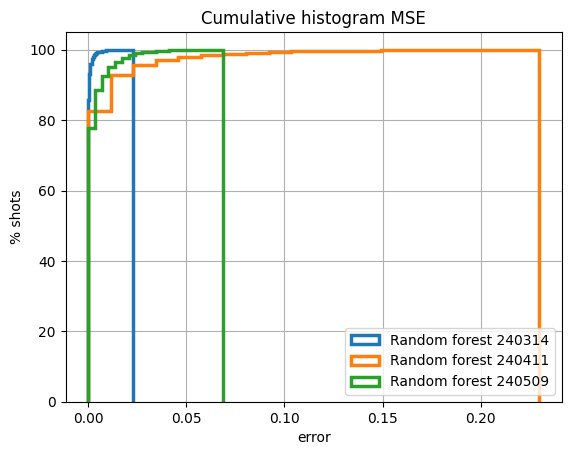

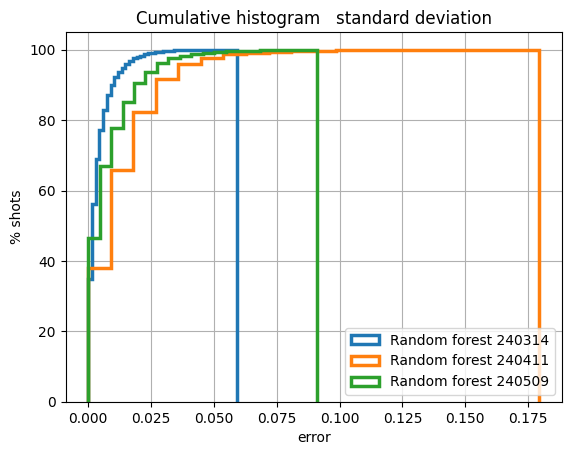

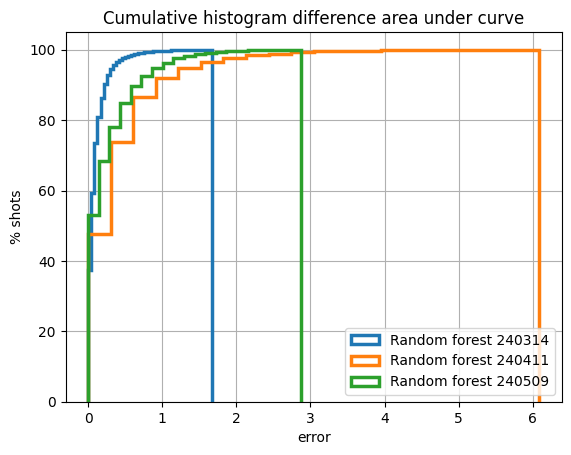

In [32]:
weights_big_forward_rf_240314 = 100*np.ones_like(df_error_big_forward_rf_240314['mae']) / len(df_error_forward_rf_240314)
weights_big_forward_rf_240411 = 100*np.ones_like(df_error_big_forward_rf_240411['mae']) / len(df_error_forward_rf_240411)
weights_big_forward_rf_240509 = 100*np.ones_like(df_error_big_forward_rf_240509['mae']) / len(df_error_forward_rf_240509)

df_error_big_forward_rf_240314['mae'].hist(bins=20,weights=weights_big_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
df_error_big_forward_rf_240411['mae'].hist(bins=20,weights=weights_big_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
df_error_big_forward_rf_240509['mae'].hist(bins=20,weights=weights_big_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram MAE')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

df_error_big_forward_rf_240314['mse'].hist(bins=40,weights=weights_big_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
df_error_big_forward_rf_240411['mse'].hist(bins=20,weights=weights_big_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
df_error_big_forward_rf_240509['mse'].hist(bins=20,weights=weights_big_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('error')
plt.title('Cumulative histogram MSE')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

df_error_big_forward_rf_240314['std'].hist(bins=40,weights=weights_big_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
df_error_big_forward_rf_240411['std'].hist(bins=20,weights=weights_big_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
df_error_big_forward_rf_240509['std'].hist(bins=20,weights=weights_big_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('error')
plt.title('Cumulative histogram   standard deviation')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

df_error_big_forward_rf_240314['area'].hist(bins=40,weights=weights_big_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
df_error_big_forward_rf_240411['area'].hist(bins=20,weights=weights_big_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
df_error_big_forward_rf_240509['area'].hist(bins=20,weights=weights_big_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')

plt.ylabel('% shots')
plt.xlabel('error')
plt.title('Cumulative histogram difference area under curve')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

### Print random predictions

In [33]:
def plot_pulse_and_prediction(shot_index,y_test,y_test_reset,y_predict,df_input,df_time_val):
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
    plt.plot(df_time_val,y_predict[shot_index],label='Prediction')
    plt.xlabel('Time (fs)')
    plt.ylabel('Intensity')
    mae='{:6.5f}'.format(mean_absolute_error(y_test_reset.loc[shot_index],y_predict[shot_index]))
    plt.title('Mean abs. error:'+mae)
    plt.legend()
    plt.show()

    return

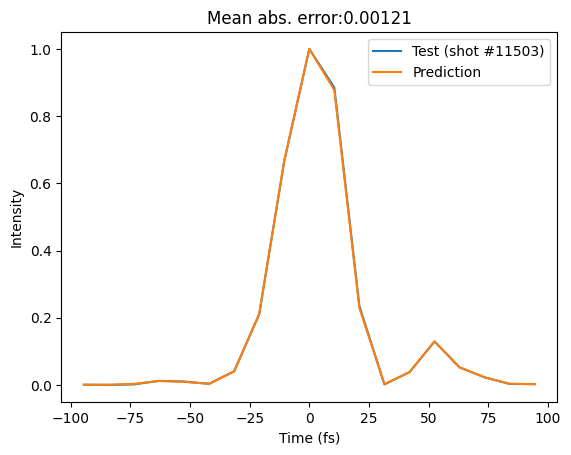

In [34]:
#240314
shot_index=314
plot_pulse_and_prediction(shot_index,y_test_240314,y_test_reset_240314,y_predict_forest_forward_240314,
                          df_input_clean_240314,df_time_val_240314)

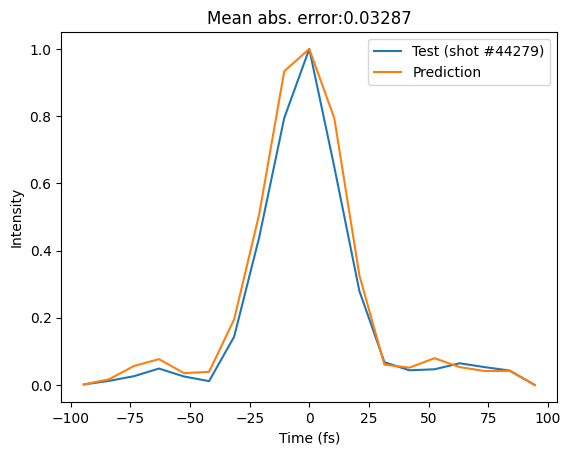

In [35]:
#240411
shot_index=330
plot_pulse_and_prediction(shot_index,y_test_240411,y_test_reset_240411,y_predict_forest_forward_240411,
                          df_input_clean_240411,df_time_val_240411)

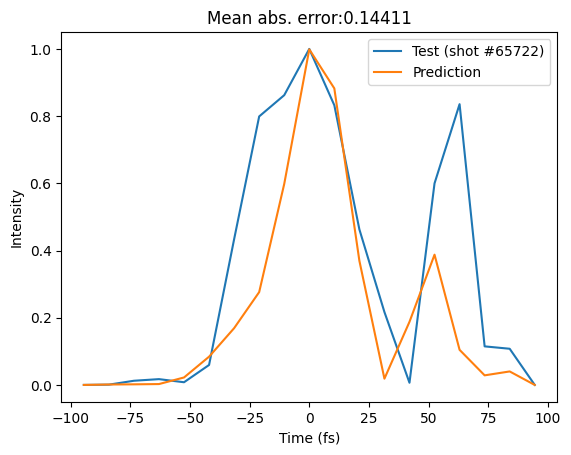

In [36]:
#240509
shot_index=330
plot_pulse_and_prediction(shot_index,y_test_240509,y_test_reset_240509,y_predict_forest_forward_240509,
                          df_input_clean_240509,df_time_val_240509)

## Error distribution in the parameter space

We want to see if there is any correlation between the largest error shots and its parameters

In [37]:
temp_error_240411=df_error_forward_rf_240411.copy()
temp_error_240411.to_frame()
temp_error_240411=temp_error_240411.set_axis(y_test_240411.index)
print(temp_error_240411)
df_error_distr=X_test_240411.copy()
df_error_distr['error prediction']=temp_error_240411
df_error_distr=df_error_distr[df_error_distr['error prediction']>0.05]
df_error_distr

1328     0.085775
11722    0.010024
976      0.072050
13499    0.055731
2310     0.018528
           ...   
7016     0.079833
6870     0.023548
808      0.021824
1651     0.031590
1333     0.079989
Length: 4530, dtype: float64


,order2,order3,order4,error prediction
1328,34900,29000,-3800000.0,0.085775
976,34900,16000,-4400000.0,0.072050
13499,35350,22000,-4000000.0,0.055731
8402,35200,-10000,-3700000.0,0.078100
6963,35150,-12000,-3800000.0,0.094069
...,...,...,...,...
7017,35150,-10000,-3800000.0,0.060595
12492,35350,-12000,-3900000.0,0.094273
4495,35050,-2000,-4500000.0,0.091474
7016,35150,-10000,-3800000.0,0.079833


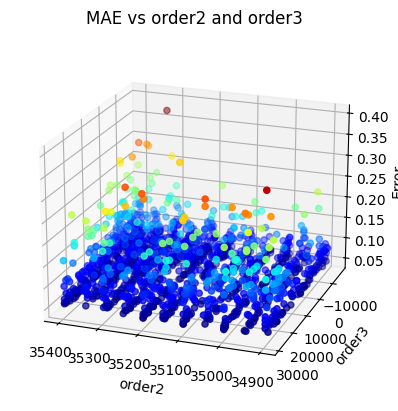

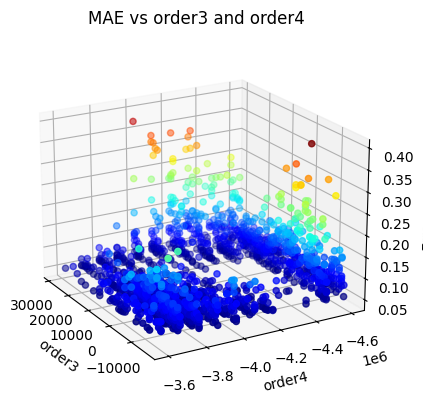

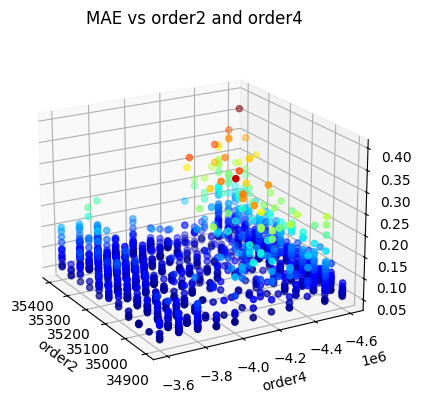

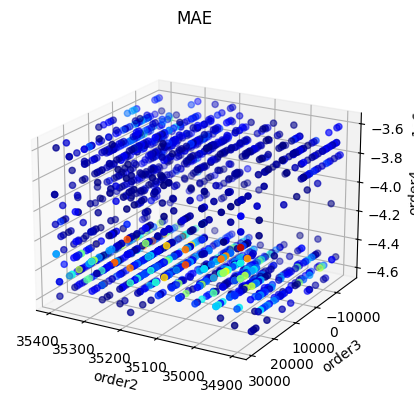

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_error_distr['order2'], df_error_distr['order3'], df_error_distr['error prediction'],c=df_error_distr['error prediction'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('Error')
ax.view_init(elev=20., azim=110)
plt.title('MAE vs order2 and order3')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
ax2.scatter(df_error_distr['order3'], df_error_distr['order4'], df_error_distr['error prediction'],c=df_error_distr['error prediction'],cmap='jet')
ax2.set_xlabel('order3')
ax2.set_ylabel('order4')
ax2.set_zlabel('Error')
ax2.view_init(elev=20., azim=150)
plt.title('MAE vs order3 and order4')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(projection='3d')
ax3.scatter(df_error_distr['order2'], df_error_distr['order4'], df_error_distr['error prediction'],c=df_error_distr['error prediction'],cmap='jet')
ax3.set_xlabel('order2')
ax3.set_ylabel('order4')
ax3.set_zlabel('Error')
ax3.view_init(elev=20., azim=150)
plt.title('MAE vs order2 and order4')
plt.show()

fig = plt.figure()
ax4 = fig.add_subplot(projection='3d')
ax4.scatter(df_error_distr['order2'], df_error_distr['order3'], df_error_distr['order4'],c=df_error_distr['error prediction'],cmap='jet')
ax4.set_xlabel('order2')
ax4.set_ylabel('order3')
ax4.set_zlabel('order4')
ax4.view_init(elev=20., azim=120)
plt.title('MAE')
#plt.tight_layout()
plt.show()

## Comparing same parameters in different datasets

In [39]:

shot_index=43#388 #from #240411
#plot_pulse_and_prediction(shot_index,y_test_240411,y_test_reset_240411,y_predict_forest_forward_240411,
 #                         df_input_clean_240411,df_time_val_240411)
shot_numb=get_shot_num(shot_index,y_test_240411,df_input_clean_240411)
#print(shot_numb)
df_temp=df_input_clean_240411[df_input_clean_240411['shot number']==shot_numb]
print(df_temp)
o2_value=df_temp['order2'].values
o3_value=df_temp['order3'].values
o4_value=df_temp['order4'].values
index_240411=df_temp.index[0]
shot_240411=df_temp['shot number'].values[0]

#print(o2_value)
#print(o3_value)
#print(o4_value)
print(' ')
df_temp=df_input_clean_240314[(df_input_clean_240314['order2']==o2_value[0])
      & (df_input_clean_240314['order3']==o3_value[0])
     & (df_input_clean_240314['order4']==o4_value[0])]
print(df_temp)
index_240314=df_temp.index[0]
shot_240314=df_temp['shot number'].values[0]

print(' ')
df_temp=df_input_clean_240509[(df_input_clean_240509['order2']==o2_value[0])
      & (df_input_clean_240509['order3']==o3_value[0])
     & (df_input_clean_240509['order4']==o4_value[0])]
print(df_temp)
index_240509=df_temp.index[0]
shot_240509=df_temp['shot number'].values[0]

      shot number  order2  order3     order4
6212        43057   35100    9000 -3800000.0
 
      shot number  order2  order3     order4
6267        11177   35100    9000 -3800000.0
6268        11178   35100    9000 -3800000.0
6269        11179   35100    9000 -3800000.0
 
      shot number  order2  order3     order4
4294        59587   35100    9000 -3800000.0
4295        59588   35100    9000 -3800000.0


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


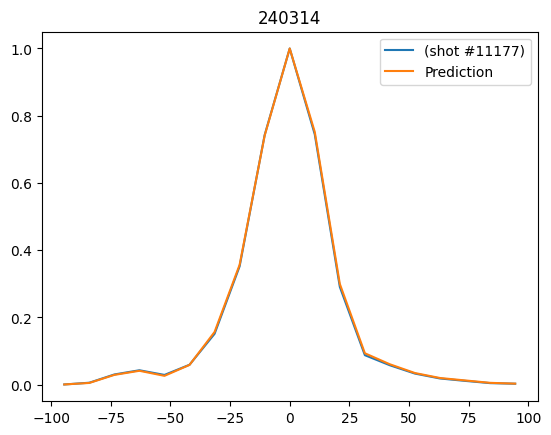

 
The mean squared error is: 1.2699150951264717e-05
The mean absolute error: 0.002540956097953181
Error in area under the curve: 0.031573061880953546
Difference in std deviation: 0.000638009401079942
 


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


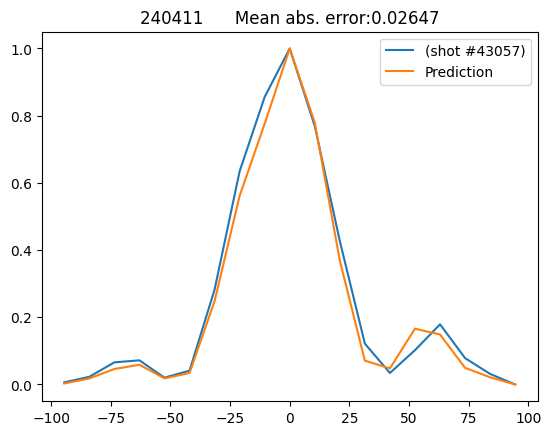

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


 
The mean squared error is: 0.001351281653878464
The mean absolute error: 0.026474064413533623
Error in area under the curve: 0.32569971909920525
Difference in std deviation: 0.010065810078224602
 


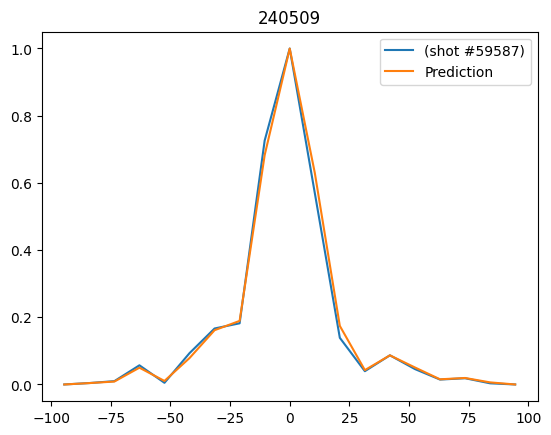

 
The mean squared error is: 0.0003760683441961338
The mean absolute error: 0.010129814596491198
Error in area under the curve: 0.04854375211110806
Difference in std deviation: 0.000351606205835131
 


In [40]:
#make a prediction and plot
input_order=np.array([o2_value[0],o3_value[0],o4_value[0]]).reshape(1, -1)

y_predict=rf.make_rf_prediction(rf_model_forward_240314,input_order)
plt.plot(df_time_val_240314,df_time_clean_240314.loc[index_240314],label='(shot #'+str(shot_240314)+')')
plt.plot(df_time_val_240314,y_predict[0],label='Prediction')
plt.legend()
plt.title('240314')
plt.show()
write_metrics(df_time_clean_240314.loc[index_240314],y_predict[0])

y_predict=rf.make_rf_prediction(rf_model_forward_240411,input_order)
plt.plot(df_time_val_240411,df_time_clean_240411.loc[index_240411],label='(shot #'+str(shot_240411)+')')
plt.plot(df_time_val_240411,y_predict[0],label='Prediction')
plt.legend()
mae='{:6.5f}'.format(mean_absolute_error(df_time_clean_240411.loc[index_240411],y_predict[0]))
plt.title('240411      Mean abs. error:'+mae)
plt.show()
write_metrics(df_time_clean_240411.loc[index_240411],y_predict[0])

y_predict=rf.make_rf_prediction(rf_model_forward_240509,input_order)
plt.plot(df_time_val_240509,df_time_clean_240509.loc[index_240509],label='(shot #'+str(shot_240509)+')')
plt.plot(df_time_val_240509,y_predict[0],label='Prediction')
plt.legend()
plt.title('240509')
plt.show()
write_metrics(df_time_clean_240509.loc[index_240509],y_predict[0])

# BACKWARD MODEL

## Linear modeling

In [41]:
#DATASET 240314
lin_model_backward_240314=lin.fit_lin_model(y_train_240314,X_train_240314)
X_predict_lin_backward_240314=lin.make_lin_prediction(lin_model_backward_240314,y_test_240314)

#DATASET 240411
lin_model_backward_240411=lin.fit_lin_model(y_train_240411,X_train_240411)
X_predict_lin_backward_240411=lin.make_lin_prediction(lin_model_backward_240411,y_test_240411)

#DATASET 240509
lin_model_backward_240509=lin.fit_lin_model(y_train_240509,X_train_240509)
X_predict_lin_backward_240509=lin.make_lin_prediction(lin_model_backward_240509,y_test_240509)

## Random forest

In [42]:
n_estimators = 300
max_features = 'sqrt'
max_depth=20
random_state=18

#DATASET 240314
rf_model_backward_240314=rf.fit_random_forest(y_train_240314,X_train_240314,n_estimators, max_features,max_depth, random_state)
X_predict_forest_backward_240314=rf.make_rf_prediction(rf_model_backward_240314,y_test_240314)

#DATASET 240411
rf_model_backward_240411=rf.fit_random_forest(y_train_240411,X_train_240411,n_estimators, max_features,max_depth, random_state)
X_predict_forest_backward_240411=rf.make_rf_prediction(rf_model_backward_240411,y_test_240411)

#DATASET 240509
rf_model_backward_240509=rf.fit_random_forest(y_train_240509,X_train_240509,n_estimators, max_features,max_depth, random_state)
X_predict_forest_backward_240509=rf.make_rf_prediction(rf_model_backward_240509,y_test_240509)

## FCNN

In [43]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [44]:
n_epochs=200
batch_size=20
print_freq=10
learning_rate=0.001

#DATASET 240314
nn_fc_model_240314 = fcnn.fit_fc_nn(X_train_240314,y_train_240314,X_test_240314,y_test_240314,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_fc_nn_240314=fcnn.make_fc_nn_prediction(nn_fc_model_240314,y_test_240314,X_train_240314,device)

#DATASET 240411
nn_fc_model_240411 = fcnn.fit_fc_nn(X_train_240411,y_train_240411,X_test_240411,y_test_240411,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_fc_nn_240411=fcnn.make_fc_nn_prediction(nn_fc_model_240411,y_test_240411,X_train_240411,device)

#DATASET 240509
nn_fc_model_240509 = fcnn.fit_fc_nn(X_train_240509,y_train_240509,X_test_240509,y_test_240509,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_fc_nn_240509=fcnn.make_fc_nn_prediction(nn_fc_model_240509,y_test_240509,X_train_240509,device)

We are using: cpu
Finished epoch 0,latest loss 0.8394377827644348
Finished epoch 10,latest loss 0.4524464011192322
Finished epoch 20,latest loss 0.38879483938217163
Finished epoch 30,latest loss 0.343990683555603
Finished epoch 40,latest loss 0.3017473816871643
Finished epoch 50,latest loss 0.28115013241767883
Finished epoch 60,latest loss 0.2653346359729767
Finished epoch 70,latest loss 0.2566147446632385
Finished epoch 80,latest loss 0.2482694685459137
Finished epoch 90,latest loss 0.24093827605247498
Finished epoch 100,latest loss 0.23632976412773132
Finished epoch 110,latest loss 0.23104849457740784
Finished epoch 120,latest loss 0.22761797904968262
Finished epoch 130,latest loss 0.2238568663597107
Finished epoch 140,latest loss 0.22029273211956024
Finished epoch 150,latest loss 0.21528935432434082
Finished epoch 160,latest loss 0.2116377055644989
Finished epoch 170,latest loss 0.20897971093654633
Finished epoch 180,latest loss 0.20485004782676697
Finished epoch 190,latest loss 0.2

## Train CNN (backward model)

In [45]:
n_epochs=100
batch_size=20
print_freq=10
learning_rate=0.001

#DATASET 240314
cnn_model_240314 = cnn.fit_cnn(X_train_240314,y_train_240314,X_test_240314,y_test_240314,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_cnn_240314=cnn.make_cnn_prediction(cnn_model_240314,y_test_240314,X_train_240314,device)

#DATASET 240411
cnn_model_240411 = cnn.fit_cnn(X_train_240411,y_train_240411,X_test_240411,y_test_240411,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_cnn_240411=cnn.make_cnn_prediction(cnn_model_240411,y_test_240411,X_train_240411,device)

#DATASET 240509
cnn_model_240509 = cnn.fit_cnn(X_train_240509,y_train_240509,X_test_240509,y_test_240509,
              n_epochs,batch_size,print_freq,learning_rate)
X_predict_cnn_240509=cnn.make_cnn_prediction(cnn_model_240509,y_test_240509,X_train_240509,device)

We are using: cpu
Finished epoch 0,latest loss 0.8358829021453857
Finished epoch 10,latest loss 0.4588971436023712
Finished epoch 20,latest loss 0.37187328934669495
Finished epoch 30,latest loss 0.30408719182014465
Finished epoch 40,latest loss 0.2779875695705414
Finished epoch 50,latest loss 0.26414695382118225
Finished epoch 60,latest loss 0.25440511107444763
Finished epoch 70,latest loss 0.24716392159461975
Finished epoch 80,latest loss 0.24211567640304565
Finished epoch 90,latest loss 0.23726943135261536
Finished epoch 99,latest loss 0.23137521743774414
Total time taken to train the model: 231.22s
We are using: cpu
Finished epoch 0,latest loss 0.784506618976593
Finished epoch 10,latest loss 0.45954570174217224
Finished epoch 20,latest loss 0.4141969382762909
Finished epoch 30,latest loss 0.3834927976131439
Finished epoch 40,latest loss 0.35797563195228577
Finished epoch 50,latest loss 0.33656829595565796
Finished epoch 60,latest loss 0.3225135803222656
Finished epoch 70,latest loss

KeyboardInterrupt: 

# ROUNDTRIP

In [ ]:
#linear model
y_predict_lin_backforw_240314=lin_model_forward_240314.predict(X_predict_lin_backward_240314)
y_predict_lin_backforw_240411=lin_model_forward_240411.predict(X_predict_lin_backward_240411)
y_predict_lin_backforw_240509=lin_model_forward_240509.predict(X_predict_lin_backward_240509)

#random forest
y_predict_backforw_240314=rf_model_forward_240314.predict(X_predict_forest_backward_240314)
y_predict_backforw_240411=rf_model_forward_240411.predict(X_predict_forest_backward_240411)
y_predict_backforw_240509=rf_model_forward_240509.predict(X_predict_forest_backward_240509)

#FC NN (using RF as forward)
y_predict_fcnn_backforw_240314=rf_model_forward_240314.predict(X_predict_fc_nn_240314)
y_predict_fcnn_backforw_240411=rf_model_forward_240411.predict(X_predict_fc_nn_240411)
y_predict_fcnn_backforw_240509=rf_model_forward_240509.predict(X_predict_fc_nn_240509)

#CNN (using RF as forward
y_predict_cnn_backforw_240314=rf_model_forward_240314.predict(X_predict_cnn_240314)
y_predict_cnn_backforw_240411=rf_model_forward_240411.predict(X_predict_cnn_240411)
y_predict_cnn_backforw_240509=rf_model_forward_240509.predict(X_predict_cnn_240509)

In [ ]:
def plot_example(shot_index,y_test,y_test_reset,df_input_subset,df_time_val,
                 y_predict_lin_backforw,y_predict_backforw,y_predict_fcnn_backforw,y_predict_cnn_backforw):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input_subset)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
    plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_backforw[shot_index],label='Prediction (Random  forest)')
    plt.plot(df_time_val,y_predict_fcnn_backforw[shot_index],label='Prediction (FC NN)')
    plt.plot(df_time_val,y_predict_cnn_backforw[shot_index],label='Prediction (CNN)')

    mae='{:6.5f}'.format(mean_absolute_error(y_test_reset.loc[shot_index],y_predict_lin_backforw[shot_index]))
    #plt.title('Mean abs. error:'+mae)
    plt.xlabel('Time(fs)')
    plt.ylabel('Intensity')
    plt.legend()

In [ ]:
plot_example(280,y_test_240314,y_test_reset_240314,df_input_clean_240314,df_time_val_240314,
             y_predict_lin_backforw_240314,
             y_predict_backforw_240314,
             y_predict_fcnn_backforw_240314,y_predict_cnn_backforw_240314)

In [ ]:
plot_example(188,y_test_240411,y_test_reset_240411,df_input_clean_240411,df_time_val_240411,
             y_predict_lin_backforw_240411,
             y_predict_backforw_240411,
             y_predict_fcnn_backforw_240411,y_predict_cnn_backforw_240411)

In [ ]:
plot_example(108,y_test_240314,y_test_reset_240314,df_input_clean_240314,df_time_val_240314,
             y_predict_lin_backforw_240314,
             y_predict_backforw_240314,
             y_predict_fcnn_backforw_240314,y_predict_cnn_backforw_240314)

### Error distribution in the roundtrip model

In [ ]:
#DATASET 240314
df_error_round_lin_240314=error_dist(y_predict_lin_backforw_240314,y_test_reset_240314)
df_error_round_rf_240314=error_dist(y_predict_backforw_240314,y_test_reset_240314)
df_error_round_fcnn_240314=error_dist(y_predict_fcnn_backforw_240314,y_test_reset_240314)
df_error_round_cnn_240314=error_dist(y_predict_cnn_backforw_240314,y_test_reset_240314)

#DATASET 240411
df_error_round_lin_240411=error_dist(y_predict_lin_backforw_240411,y_test_reset_240411)
df_error_round_rf_240411=error_dist(y_predict_backforw_240411,y_test_reset_240411)
df_error_round_fcnn_240411=error_dist(y_predict_fcnn_backforw_240411,y_test_reset_240411)
df_error_round_cnn_240411=error_dist(y_predict_cnn_backforw_240411,y_test_reset_240411)

#DATASET 240509
df_error_round_lin_240509=error_dist(y_predict_lin_backforw_240509,y_test_reset_240509)
df_error_round_rf_240509=error_dist(y_predict_backforw_240509,y_test_reset_240509)
df_error_round_fcnn_240509=error_dist(y_predict_fcnn_backforw_240509,y_test_reset_240509)
df_error_round_cnn_240509=error_dist(y_predict_cnn_backforw_240509,y_test_reset_240509)

In [ ]:
df_error_round_rf_240314.hist(bins=20,weights=weights_forward_rf_240314,histtype="step",linewidth=2.5, label='Random forest 240314')
df_error_round_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='Random forest 240411')
df_error_round_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram ')#     (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_round_rf_240314.hist(bins=20,weights=weights_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240314')
df_error_round_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240411')
df_error_round_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Random forest 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram ')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

In [ ]:
df_error_round_fcnn_240314.hist(bins=20,weights=weights_forward_rf_240314,histtype="step",linewidth=2.5, label='FCNN 240314')
df_error_round_fcnn_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='FCNN 240411')
df_error_round_fcnn_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='FCNN 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram ')#     (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_round_fcnn_240314.hist(bins=20,weights=weights_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='FCNN 240314')
df_error_round_fcnn_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='FCNN 240411')
df_error_round_fcnn_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='FCNN 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram ')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

In [ ]:
df_error_round_cnn_240314.hist(bins=20,weights=weights_forward_rf_240314,histtype="step",linewidth=2.5, label='CNN 240314')
df_error_round_cnn_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='CNN 240411')
df_error_round_cnn_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='CNN 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram ')#     (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_round_cnn_240314.hist(bins=20,weights=weights_forward_rf_240314,cumulative=True,histtype="step",linewidth=2.5,label='CNN 240314')
df_error_round_cnn_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='CNN 240411')
df_error_round_cnn_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='CNN 240509')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram ')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

# Predictions without trainig (using first day model 240314)

In [ ]:

#Prediction for #DATASET 240411
#backward
X_predict_forest_backward_old_240411=rf.make_rf_prediction(rf_model_backward_240314,y_test_240411)
#forward
y_predict_backforw_old_240411=rf_model_forward_240314.predict(X_predict_forest_backward_old_240411)

#Prediction for #DATASET 240509
#backward
X_predict_forest_backward_old_240509=rf.make_rf_prediction(rf_model_backward_240314,y_test_240509)
#forward
y_predict_backforw_old_240509=rf_model_forward_240314.predict(X_predict_forest_backward_old_240509)

In [ ]:
df_error_round_rf_old_240411=error_dist(y_predict_backforw_old_240411,y_test_reset_240411)
df_error_round_rf_old_240509=error_dist(y_predict_backforw_old_240509,y_test_reset_240509)

In [ ]:
df_error_round_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='New Random forest')
df_error_round_rf_old_240411.hist(bins=20,weights=weights_forward_rf_240411,histtype="step",linewidth=2.5, label='Old Random forest')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram 240411')#     (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_round_rf_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='New Random forest')
df_error_round_rf_old_240411.hist(bins=20,weights=weights_forward_rf_240411,cumulative=True,histtype="step",linewidth=2.5,label='Old Random forest')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram 240411')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

In [ ]:
df_error_round_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='New Random forest')
df_error_round_rf_old_240509.hist(bins=20,weights=weights_forward_rf_240509,histtype="step",linewidth=2.5, label='Old Random forest')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Histogram 240509')#     (total num. shots='+str(len(weights_forward_lin_240509))+')')
plt.legend()
plt.show()

df_error_round_rf_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='New Random forest')
df_error_round_rf_old_240509.hist(bins=20,weights=weights_forward_rf_240509,cumulative=True,histtype="step",linewidth=2.5,label='Old Random forest')
plt.ylabel('% shots')
plt.xlabel('Abs. error')
plt.title('Cumulative histogram 240509')# 240509    (total num. shots='+str(len(df_error_forward_rf_240509))+')')
plt.legend()
plt.show()

In [ ]:
shot_index=155
shot_numb=get_shot_num(shot_index,y_test_reset_240509,df_input_clean_240509)
plt.plot(df_time_val_240509,y_test_reset_240509.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
plt.plot(df_time_val_240509,y_predict_backforw_240509[shot_index],label='New RF model')
plt.plot(df_time_val_240509,y_predict_backforw_old_240509[shot_index],label='Old RF Model')

plt.xlabel('Time(fs)')
plt.ylabel('Intensity')
plt.title('240509  Roundtrip')
plt.legend()

In [ ]:
shot_index=2855
shot_numb=get_shot_num(shot_index,y_test_reset_240509,df_input_clean_240509)
plt.plot(df_time_val_240509,y_test_reset_240509.loc[shot_index],label='Test (shot #'+str(shot_numb)+')')
plt.plot(df_time_val_240509,y_predict_backforw_240509[shot_index],label='New RF model')
plt.plot(df_time_val_240509,y_predict_backforw_old_240509[shot_index],label='Old RF Model')

plt.xlabel('Time(fs)')
plt.ylabel('Intensity')
plt.title('240509  Roundtrip')
plt.legend()